#ПРАКТИЧЕСКАЯ РАБОТА №1: ПОЛНОСВЯЗНАЯ НЕЙРОННАЯ СЕТЬ

##Часть 1: Общий пример на MNIST

###Импортируйте необходимые библиотеки (TensorFlow/PyTorch, Matplotlib, NumPy)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

###Загрузите датасет MNIST (из библиотек keras.datasets или torchvision.datasets). Разделите его на обучающую и тестовую выборки

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) #здесь приводим датасет к виду тензоора и нормализуем его
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #задаём подгрузчики данных
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

###Постройте полносвязную нейронную сеть с использованием следующих параметров:
• Входной слой, преобразующий
изображение 28x28 в вектор длины 784.
• Один или два скрытых слоя (например, с 128 и 64 нейронами).
• Функция активации: ReLU в скрытых слоях и Softmax на выходе.
• Функция потерь: кросс-энтропия.
• Оптимизатор: SGD или Adam.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

In [ ]:
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

###Обучите модель на обучающей выборке и оцените точность на тестовых данных

In [ ]:
epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def compute_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(compute_accuracy(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(compute_accuracy(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

Epoch 1/10, Loss: 1.6429, Test Loss: 1.5480, Train Acc: 0.9159, Test Acc: 0.9192
Epoch 2/10, Loss: 1.5479, Test Loss: 1.5396, Train Acc: 0.9230, Test Acc: 0.9251
Epoch 3/10, Loss: 1.5320, Test Loss: 1.5263, Train Acc: 0.9382, Test Acc: 0.9369
Epoch 4/10, Loss: 1.5225, Test Loss: 1.5260, Train Acc: 0.9373, Test Acc: 0.9368
Epoch 5/10, Loss: 1.5165, Test Loss: 1.5171, Train Acc: 0.9457, Test Acc: 0.9452
Epoch 6/10, Loss: 1.5114, Test Loss: 1.5163, Train Acc: 0.9489, Test Acc: 0.9461
Epoch 7/10, Loss: 1.5071, Test Loss: 1.5056, Train Acc: 0.9604, Test Acc: 0.9556
Epoch 8/10, Loss: 1.5045, Test Loss: 1.5057, Train Acc: 0.9613, Test Acc: 0.9559
Epoch 9/10, Loss: 1.5017, Test Loss: 1.5022, Train Acc: 0.9640, Test Acc: 0.9588
Epoch 10/10, Loss: 1.4990, Test Loss: 1.5002, Train Acc: 0.9673, Test Acc: 0.9614


###Постройте графики:
• Потери (loss) на обучающей и тестовой выборках.
• Точность классификации на обучении и тестировании

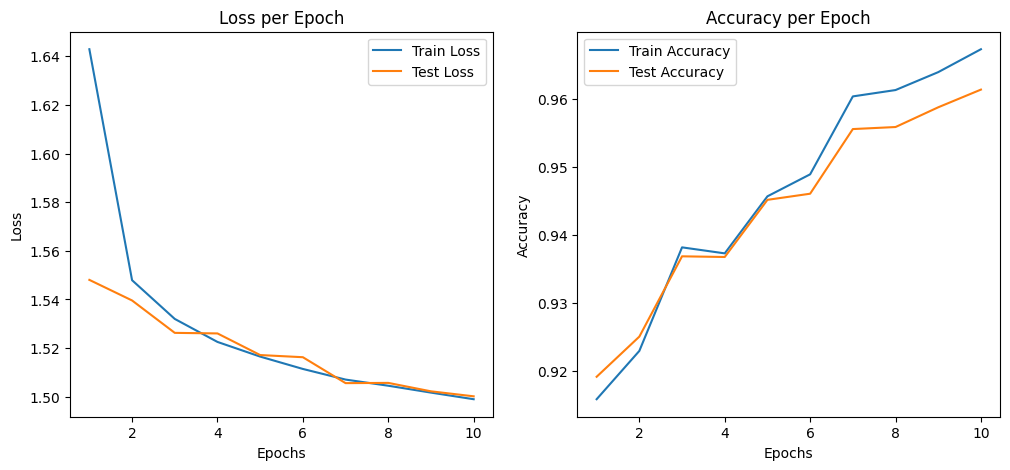

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

In [ ]:
model.eval()
incorrect_samples = []
incorrect_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect_samples.append(images[i])
                incorrect_labels.append(predicted[i].item())
                true_labels.append(labels[i].item())
                if len(incorrect_samples) >= 10:
                    break
        if len(incorrect_samples) >= 10:
            break

###Добавьте визуализацию ошибок классификации (например, изображения неверно классифицированных цифр).

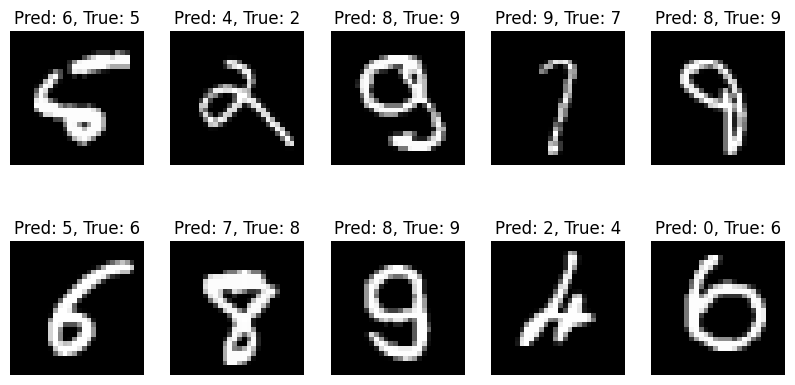

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = incorrect_samples[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Pred: {incorrect_labels[i]}, True: {true_labels[i]}')
    ax.axis('off')
plt.show()

## Часть 2: Индивидуальные задания
В качестве датасета будем использовать CIFAR-10, состоящий из изображений 10-ти классов

###Загрузка данных и преобразование их

In [ ]:
from sklearn.metrics import accuracy_score

batch_size = 64
epochs = 10
learning_rate = 0.001
hidden_sizes = [128, 256, 512]
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


###Постройте полносвязную нейронную сеть для своей задачи классификации.
Требования:
• Минимум 3 слоя (входной, один или два скрытых, выходной).
• Попробуйте разные размеры скрытых слоев (128, 256, 512
нейронов) и функции активации (ReLU, Sigmoid, Tanh).
• Подберите гиперпараметры: количество эпох, размер минивыборки (batch size), метод оптимизации

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_size, activation, dropout_rate=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 10)
        self.activation = activation
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


def train_model(model, train_loader, test_loader, epochs, optimizer, criterion):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    train_f1s, test_f1s = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(accuracy_score(all_labels, all_preds))
        train_f1s.append(f1_score(all_labels, all_preds, average='macro'))
        model.eval()
        test_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_losses.append(test_loss / len(test_loader))
        test_accs.append(accuracy_score(all_labels, all_preds))
        test_f1s.append(f1_score(all_labels, all_preds, average='macro'))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")

    return train_losses, test_losses, train_accs, test_accs, train_f1s, test_f1s

Проведём обучение нескольких моделей, подбирая необходимые функции активации, размеры скрытых слоёв, количество эпох

In [ ]:
results = {}
for activation in activation_functions:
    for hidden_size in hidden_sizes:
        print(f"Функция активации: {activation}, Скрытый размер: {hidden_size}")
        model = MLP(hidden_size=hidden_size, activation=activation, dropout_rate=0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_losses, test_losses, train_accs, test_accs, train_f1s, test_f1s = train_model(model, train_loader, test_loader, epochs, optimizer, criterion)
        results[(str(activation), hidden_size)] = (train_losses, test_losses, train_accs, test_accs)

Функция активации: ReLU(), Скрытый размер: 128
Epoch 1/10, Loss: 1.6476, Test Loss: 1.5062, Train Acc: 0.4173, Test Acc: 0.4720
Epoch 2/10, Loss: 1.4475, Test Loss: 1.4367, Train Acc: 0.4904, Test Acc: 0.4960
Epoch 3/10, Loss: 1.3549, Test Loss: 1.4198, Train Acc: 0.5228, Test Acc: 0.5009
Epoch 4/10, Loss: 1.2861, Test Loss: 1.4037, Train Acc: 0.5469, Test Acc: 0.5072
Epoch 5/10, Loss: 1.2294, Test Loss: 1.3676, Train Acc: 0.5654, Test Acc: 0.5251
Epoch 6/10, Loss: 1.1781, Test Loss: 1.3738, Train Acc: 0.5870, Test Acc: 0.5204
Epoch 7/10, Loss: 1.1299, Test Loss: 1.3933, Train Acc: 0.6016, Test Acc: 0.5142
Epoch 8/10, Loss: 1.0939, Test Loss: 1.4086, Train Acc: 0.6158, Test Acc: 0.5187
Epoch 9/10, Loss: 1.0543, Test Loss: 1.4176, Train Acc: 0.6284, Test Acc: 0.5166
Epoch 10/10, Loss: 1.0194, Test Loss: 1.4172, Train Acc: 0.6398, Test Acc: 0.5246
Функция активации: ReLU(), Скрытый размер: 256
Epoch 1/10, Loss: 1.6348, Test Loss: 1.4803, Train Acc: 0.4233, Test Acc: 0.4754
Epoch 2/10, Lo

###Визуализируйте процесс обучения с использованием Matplotlib или TensorBoard:
• Графики потерь и точности на обучении и тестировании.

Здесь мы сравним точность всех моделей **(часть 3 пункт 1)**

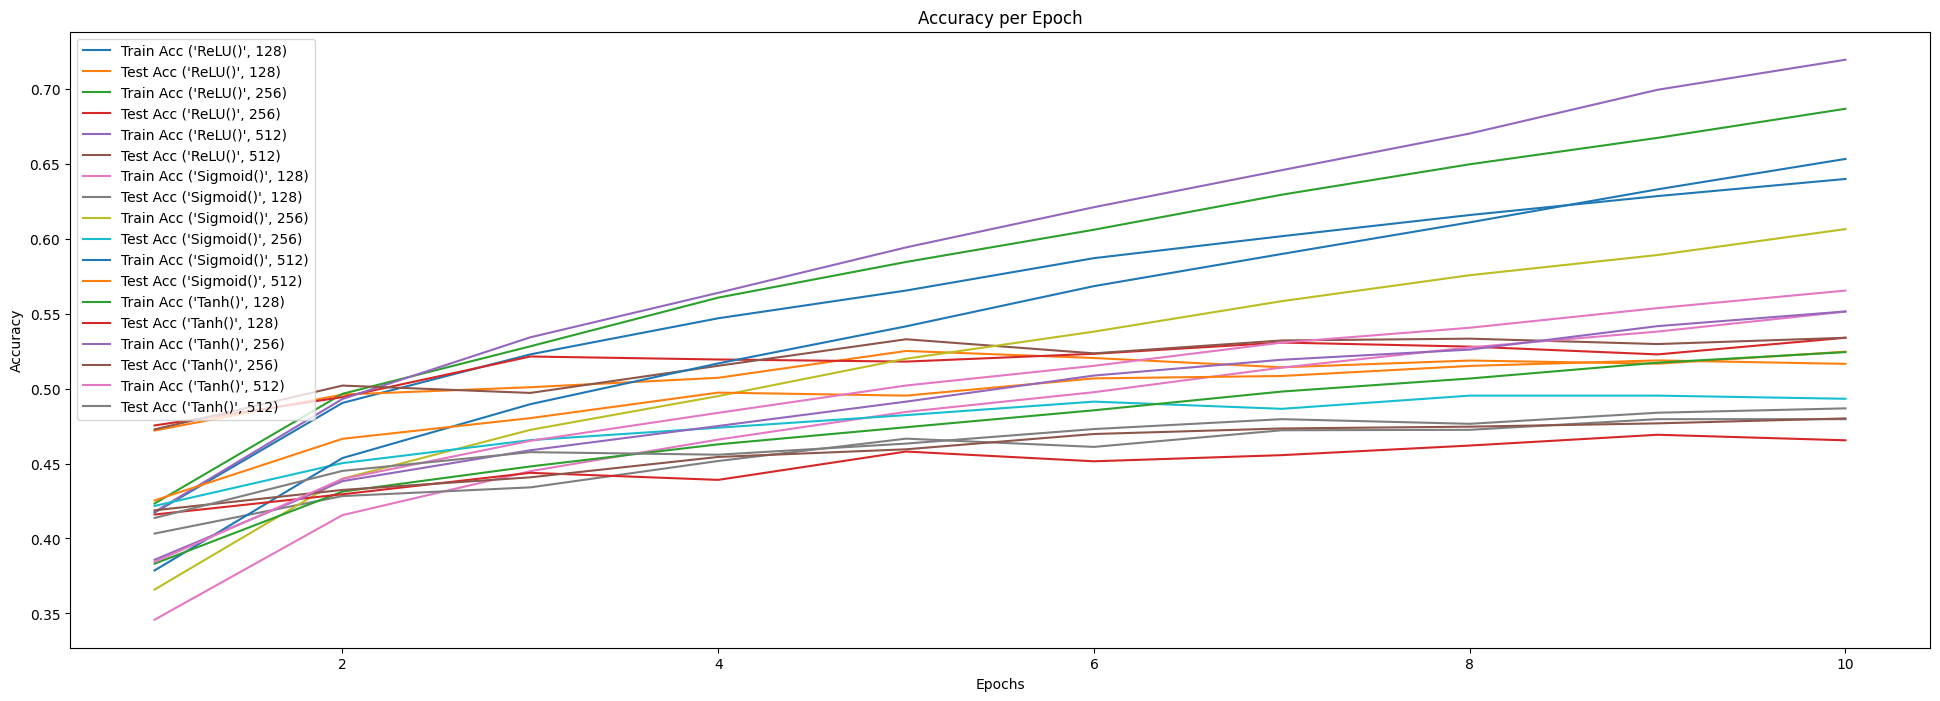

('ReLU()', 128): Train Accuracy=0.6398, Test Accuracy=0.5246, Train F1=0.5628, Test F1=0.4840
('ReLU()', 256): Train Accuracy=0.6866, Test Accuracy=0.5339, Train F1=0.5628, Test F1=0.4840
('ReLU()', 512): Train Accuracy=0.7194, Test Accuracy=0.5339, Train F1=0.5628, Test F1=0.4840
('Sigmoid()', 128): Train Accuracy=0.5513, Test Accuracy=0.4796, Train F1=0.5628, Test F1=0.4840
('Sigmoid()', 256): Train Accuracy=0.6064, Test Accuracy=0.4932, Train F1=0.5628, Test F1=0.4840
('Sigmoid()', 512): Train Accuracy=0.6532, Test Accuracy=0.5165, Train F1=0.5628, Test F1=0.4840
('Tanh()', 128): Train Accuracy=0.5243, Test Accuracy=0.4655, Train F1=0.5628, Test F1=0.4840
('Tanh()', 256): Train Accuracy=0.5515, Test Accuracy=0.4801, Train F1=0.5628, Test F1=0.4840
('Tanh()', 512): Train Accuracy=0.5654, Test Accuracy=0.4868, Train F1=0.5628, Test F1=0.4840


In [ ]:
plt.figure(figsize=(24, 8))
for key, (train_losses, test_losses, train_accs, test_accs) in results.items():
    plt.plot(range(1, epochs+1), train_accs, label=f'Train Acc {key}')
    plt.plot(range(1, epochs+1), test_accs, label=f'Test Acc {key}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()

for key, (train_losses, test_losses, train_accs, test_accs) in results.items():
    print(f"{key}: Train Accuracy={train_accs[-1]:.4f}, Test Accuracy={test_accs[-1]:.4f}, Train F1={train_f1s[-1]:.4f}, Test F1={test_f1s[-1]:.4f}")

#4. Проведите анализ переобучения. Включите Dropout в архитектуру сети и сравните результаты с его использованием и без него.

###Выберем лучшую модель и обучим её с Dropout. Лучшей моделью оказалась нейронная сеть с активацией ReLU и числом скрытых слоёв == 512

In [ ]:
model = MLP(hidden_size=512, activation=nn.ReLU(), dropout_rate=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses, test_losses, train_accs, test_accs, train_f1s, test_f1s = train_model(model, train_loader, test_loader, epochs, optimizer, criterion)

Epoch 1/10, Loss: 1.7046, Test Loss: 1.5733, Train Acc: 0.3943, Test Acc: 0.4364
Epoch 2/10, Loss: 1.5394, Test Loss: 1.4852, Train Acc: 0.4578, Test Acc: 0.4738
Epoch 3/10, Loss: 1.4637, Test Loss: 1.4475, Train Acc: 0.4839, Test Acc: 0.4905
Epoch 4/10, Loss: 1.4097, Test Loss: 1.3974, Train Acc: 0.5008, Test Acc: 0.5132
Epoch 5/10, Loss: 1.3589, Test Loss: 1.3915, Train Acc: 0.5176, Test Acc: 0.5190
Epoch 6/10, Loss: 1.3195, Test Loss: 1.3700, Train Acc: 0.5319, Test Acc: 0.5238
Epoch 7/10, Loss: 1.2797, Test Loss: 1.3579, Train Acc: 0.5457, Test Acc: 0.5283
Epoch 8/10, Loss: 1.2462, Test Loss: 1.3876, Train Acc: 0.5554, Test Acc: 0.5145
Epoch 9/10, Loss: 1.2162, Test Loss: 1.3434, Train Acc: 0.5673, Test Acc: 0.5299
Epoch 10/10, Loss: 1.1808, Test Loss: 1.3688, Train Acc: 0.5784, Test Acc: 0.5282


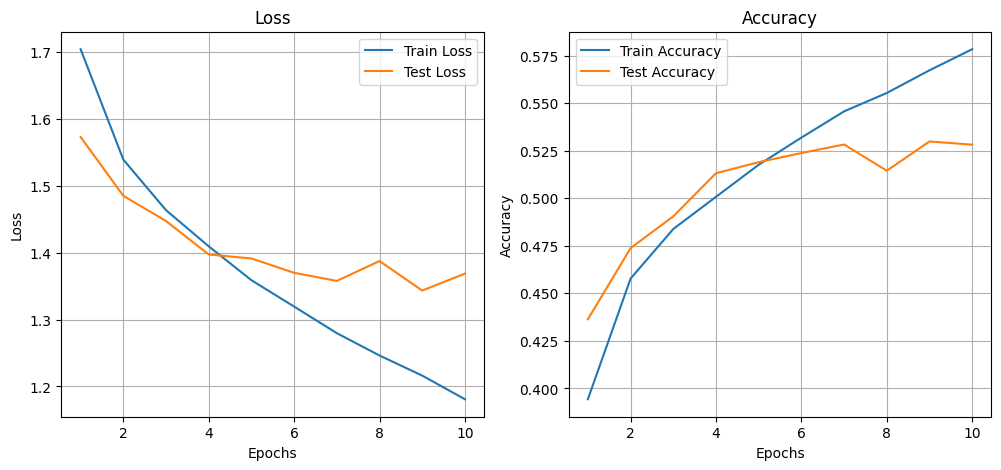

In [ ]:
epochs_range = range(1, len(train_losses) + 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(epochs_range, train_losses, label="Train Loss")
axs[0].plot(epochs_range, test_losses, label="Test Loss")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid()

axs[1].plot(epochs_range, train_accs, label="Train Accuracy")
axs[1].plot(epochs_range, test_accs, label="Test Accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid()

plt.show()

##Часть 3: Сравнительный анализ и защита

In [ ]:
print("Модели без Dropout")
for key, (train_losses, test_losses, train_accs, test_accs) in results.items():
    print(f"{key}: Train Accuracy={train_accs[-1]:.4f}, Test Accuracy={test_accs[-1]:.4f}, Train F1={train_f1s[-1]:.4f}, Test F1={test_f1s[-1]:.4f}")
print("Модель с Dropout")
print(f"Train Accuracy: {train_accs[-1]:.4f}, Test Accuracy: {test_accs[-1]:.4f}, Train F1={train_f1s[-1]:.4f}, Test F1={test_f1s[-1]:.4f}")

Модели без Dropout
('ReLU()', 128): Train Accuracy=0.6398, Test Accuracy=0.5246, Train F1=0.5770, Test F1=0.5278
('ReLU()', 256): Train Accuracy=0.6866, Test Accuracy=0.5339, Train F1=0.5770, Test F1=0.5278
('ReLU()', 512): Train Accuracy=0.7194, Test Accuracy=0.5339, Train F1=0.5770, Test F1=0.5278
('Sigmoid()', 128): Train Accuracy=0.5513, Test Accuracy=0.4796, Train F1=0.5770, Test F1=0.5278
('Sigmoid()', 256): Train Accuracy=0.6064, Test Accuracy=0.4932, Train F1=0.5770, Test F1=0.5278
('Sigmoid()', 512): Train Accuracy=0.6532, Test Accuracy=0.5165, Train F1=0.5770, Test F1=0.5278
('Tanh()', 128): Train Accuracy=0.5243, Test Accuracy=0.4655, Train F1=0.5770, Test F1=0.5278
('Tanh()', 256): Train Accuracy=0.5515, Test Accuracy=0.4801, Train F1=0.5770, Test F1=0.5278
('Tanh()', 512): Train Accuracy=0.5654, Test Accuracy=0.4868, Train F1=0.5770, Test F1=0.5278
Модель с Dropout
Train Accuracy: 0.5654, Test Accuracy: 0.4868, Train F1=0.5770, Test F1=0.5278
